## Import Libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, make_union

In [3]:
from imblearn.over_sampling import SMOTE

## Load Datasets

In [4]:
test_df = pd.read_csv('data/data_test.csv', index_col='id')
print('Shape of Test Dataset = ', test_df.shape) # ~ 9L rows with 56 cols
test_df.head()

Shape of Test Dataset =  (892816, 56)


num1  num2  num3  num4  num5  num6  num7  num8  num9  num10  ...    cat5  \
id                                                               ...           
0      0     8     0     1     0     0     0     0     0      0  ...     1.0   
1      4     5     0     0     0     1     0     0     0      0  ...     1.0   
2      5     3     0     0     0     1     0     0     0      0  ...     1.0   
3      0     6     1     0     0     0     0     0     0      0  ...     1.0   
4      5     7     0     0     0     1     0     0     0      0  ...     1.0   

    cat6  cat7  cat8  cat9  cat10  cat11  cat12  cat13  cat14  
id                                                             
0    NaN     0   NaN     1    1.0      1    2.0      1     65  
1    NaN     0   0.0    11    1.0      1    0.0      1    103  
2    NaN     0   NaN    14    1.0      1    2.0      1     29  
3    NaN     0   NaN     1    1.0      1    2.0      1     40  
4    NaN     0   NaN    11    1.0      1    2.0      1    101  

[5 rows x 56 columns]

In [5]:
train_df = pd.read_csv('data/data_train.csv', index_col='id')
print('Shape of Train Dataset = ', train_df.shape) # ~ 6L rows with 57 cols (incl. the Target col.)
train_df.head()

Shape of Train Dataset =  (596000, 57)


num1  num2  num3  num4  num5  num6  num7  num8  num9  num10   ...    cat6  \
id                                                                ...           
0      2     5     0     1     0     0     0     0     0      0   ...     NaN   
1      1     7     0     0     1     0     0     0     0      0   ...     NaN   
2      5     9     0     0     1     0     0     0     0      0   ...     NaN   
3      0     2     1     0     0     0     0     0     0      0   ...     0.0   
4      0     0     1     0     0     0     0     0     0      0   ...     NaN   

    cat7  cat8  cat9  cat10  cat11  cat12  cat13  cat14  target  
id                                                               
0      0   1.0     4    1.0      0    0.0      1     12       0  
1      0   NaN    11    1.0      1    2.0      1     19       0  
2      0   NaN    14    1.0      1    2.0      1     60       0  
3      0   1.0    11    1.0      1    3.0      1    104       0  
4      0   NaN    14    1.0      1    2.0      1     82       0  

[5 rows x 57 columns]

## EDA

#### Check for data imbalance

In [6]:
# Imbalanced data-distribution?
train_df.target.value_counts()

0    574284
1     21716
Name: target, dtype: int64

In [7]:
count_total = train_df.shape[0]
count_0 = train_df.loc[train_df['target'] == 0].shape[0]
count_1 = train_df.loc[train_df['target'] == 1].shape[0]
perc_0 = (count_0 / count_total) * 100
perc_1 = (count_1 / count_total) * 100

print('perc_0 = ', round(perc_0, 2))
print('perc_1 = ', round(perc_1, 2))

perc_0 =  96.36
perc_1 =  3.64


#### Check for columns having NaN values in datasets and Fill it up

In [8]:
res = test_df.isnull().sum()
test_nan_cols = res[res>0]
print('test_nan_cols = ', test_nan_cols.index.values)
print(test_nan_cols.sort_values(ascending=False))

test_nan_cols =  ['num18' 'num19' 'num22' 'cat1' 'cat2' 'cat3' 'cat4' 'cat5' 'cat6' 'cat8'
 'cat10' 'cat12']
cat6     616911
cat8     400359
num18    161684
num22     63805
cat10     17331
cat3       8710
cat12       877
cat1        307
cat4        160
cat2        145
cat5          5
num19         1
dtype: int64


In [9]:
res = train_df.isnull().sum()
train_nan_cols = res[res>0]
print('train_nan_cols = ', train_nan_cols.index.values)
print(train_nan_cols.sort_values(ascending=False))

train_nan_cols =  ['num18' 'num19' 'num20' 'num22' 'cat1' 'cat2' 'cat3' 'cat4' 'cat5' 'cat6'
 'cat8' 'cat10' 'cat12']
cat6     411792
cat8     266928
num18    107909
num22     42667
cat10     11503
cat3       5814
cat12       570
cat1        217
cat4        107
cat2         83
cat5          5
num19         5
num20         1
dtype: int64


In [10]:
# train_df.info()

In [11]:
train_df.cat6.value_counts()

1.0    110846
0.0     73362
Name: cat6, dtype: int64

In [12]:
train_df.cat8.value_counts()

1.0    172883
0.0    156189
Name: cat8, dtype: int64

In [13]:
train_df.cat10.value_counts()

1.0    553874
0.0     30623
Name: cat10, dtype: int64

In [14]:
train_df.cat3.value_counts()

0.0    528704
6.0     20698
4.0     18372
1.0      8331
3.0      8243
2.0      4186
5.0      1652
Name: cat3, dtype: int64

In [15]:
train_df[['num18', 'num22']].describe()

num18          num22
count  488091.000000  553333.000000
mean        0.894025       0.374691
std         0.345393       0.045607
min         0.061237       0.109545
25%         0.633443       0.350428
50%         0.801561       0.373497
75%         1.083974       0.398121
max         4.037945       0.636396

In [16]:
train_df[['num18', 'num22']].mode().iloc[0]

num18    0.633936
num22    0.361525
Name: 0, dtype: float64

In [17]:
cat_cols = []
for i in range(1,15):
    cat_cols.append("cat{}".format(i))
print(cat_cols)

['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14']


In [18]:
other_cols = [col for col in train_df.columns if col not in cat_cols]
print(other_cols)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21', 'num22', 'num23', 'der1', 'der2', 'der3', 'der4', 'der5', 'der6', 'der7', 'der8', 'der9', 'der10', 'der11', 'der12', 'der13', 'der14', 'der15', 'der16', 'der17', 'der18', 'der19', 'target']


In [19]:
train_df['cat6_was_missing'] = train_df.cat6.isna()
train_df['cat6_was_missing'] = train_df['cat6_was_missing'].astype(np.int8) # Converts bool to int
train_df['cat6_was_missing'].value_counts()

1    411792
0    184208
Name: cat6_was_missing, dtype: int64

In [20]:
train_df['cat8_was_missing'] = train_df.cat8.isna()
train_df['cat8_was_missing'] = train_df['cat8_was_missing'].astype(np.int8)
train_df['cat8_was_missing'].value_counts()

0    329072
1    266928
Name: cat8_was_missing, dtype: int64

In [21]:
# First do explicit fillna for cols with large missing values
cols_almost_empty = ['cat6', 'cat8']
train_df[cols_almost_empty] = train_df[cols_almost_empty].fillna(999) # No negative number! 
#You may want to create ismissing cols for these??

train_df[cat_cols] = train_df[cat_cols].fillna(train_df[cat_cols].mode().iloc[0])
train_df[other_cols] = train_df[other_cols].fillna(train_df[other_cols].mode().iloc[0])

train_df.head()

num1  num2  num3  num4  num5  num6  num7  num8  num9  num10  \
id                                                                
0      2     5     0     1     0     0     0     0     0      0   
1      1     7     0     0     1     0     0     0     0      0   
2      5     9     0     0     1     0     0     0     0      0   
3      0     2     1     0     0     0     0     0     0      0   
4      0     0     1     0     0     0     0     0     0      0   

          ...          cat8  cat9  cat10  cat11  cat12  cat13  cat14  target  \
id        ...                                                                  
0         ...           1.0     4    1.0      0    0.0      1     12       0   
1         ...         999.0    11    1.0      1    2.0      1     19       0   
2         ...         999.0    14    1.0      1    2.0      1     60       0   
3         ...           1.0    11    1.0      1    3.0      1    104       0   
4         ...         999.0    14    1.0      1    2.0      1     82       0   

    cat6_was_missing  cat8_was_missing  
id                                      
0                  1                 0  
1                  1                 1  
2                  1                 1  
3                  0                 0  
4                  1                 1  

[5 rows x 59 columns]

In [22]:
for col in cat_cols:
#     print("Category Values in {}:".format(col))
    train_df[col] = train_df[col].astype(np.int16).astype('category')
#     print(train_df[col].value_counts())

In [23]:
train_df['cat6_was_missing'] = train_df['cat6_was_missing'].astype('category')
train_df['cat8_was_missing'] = train_df['cat8_was_missing'].astype('category')

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596000 entries, 0 to 595999
Data columns (total 59 columns):
num1                596000 non-null int64
num2                596000 non-null int64
num3                596000 non-null int64
num4                596000 non-null int64
num5                596000 non-null int64
num6                596000 non-null int64
num7                596000 non-null int64
num8                596000 non-null int64
num9                596000 non-null int64
num10               596000 non-null int64
num11               596000 non-null int64
num12               596000 non-null int64
num13               596000 non-null int64
num14               596000 non-null int64
num15               596000 non-null int64
num16               596000 non-null float64
num17               596000 non-null float64
num18               596000 non-null float64
num19               596000 non-null float64
num20               596000 non-null float64
num21               596000 non-null flo

#### Find correlation between features and with the target

In [25]:
corr = train_df.corr()

In [26]:
corr.style.background_gradient().set_precision(1)

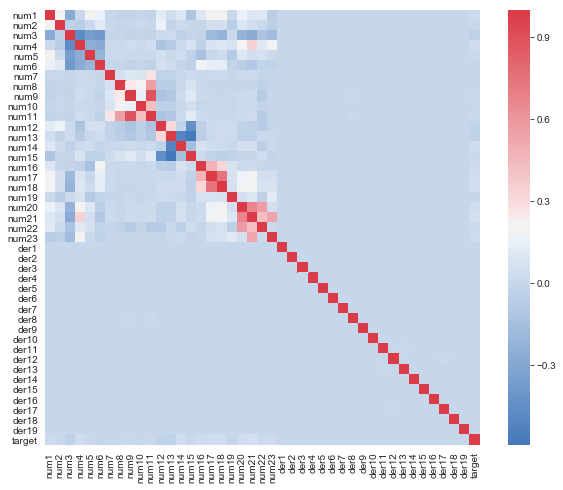

In [27]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, 
            cmap=sns.diverging_palette(250, 10, as_cmap=True),
            ax=ax, 
            square=True)

# derived columns bears no correlation whatsoever with any. Noise??
# col num11 seem to be strongly correlated with col num9 and well correlated with col num8
# col num4 seem to be strongly inversely-correlated with col num3

In [28]:
corr_pairs = corr.unstack().abs().sort_values(ascending=False)

In [29]:
corr_pairs[corr_pairs>=1].sort_index()

der1    der1      1.0
der10   der10     1.0
der11   der11     1.0
der12   der12     1.0
der13   der13     1.0
der14   der14     1.0
der15   der15     1.0
der16   der16     1.0
der17   der17     1.0
der18   der18     1.0
der19   der19     1.0
der2    der2      1.0
der3    der3      1.0
der4    der4      1.0
der5    der5      1.0
der6    der6      1.0
der7    der7      1.0
der8    der8      1.0
der9    der9      1.0
num1    num1      1.0
num10   num10     1.0
num11   num11     1.0
num12   num12     1.0
num13   num13     1.0
num14   num14     1.0
num15   num15     1.0
num16   num16     1.0
num17   num17     1.0
num18   num18     1.0
num19   num19     1.0
num2    num2      1.0
num20   num20     1.0
num21   num21     1.0
num22   num22     1.0
num23   num23     1.0
num3    num3      1.0
num4    num4      1.0
num5    num5      1.0
num6    num6      1.0
num7    num7      1.0
num8    num8      1.0
num9    num9      1.0
target  target    1.0
dtype: float64

In [30]:
corr_pairs.drop_duplicates().head(10)

target  target    1.000000
num9    num11     0.890035
num18   num17     0.749105
num21   num20     0.672029
num13   num15     0.594279
num22   num20     0.571185
num11   num8      0.564804
num23   num21     0.529491
num14   num13     0.518060
num4    num3      0.473988
dtype: float64

In [31]:
der_cols = list( map(lambda x: "der{}".format(x), range(1,20)) )
non_der_cols = [x for x in train_df.columns if x not in der_cols]
non_der_cols.remove('target')
print(non_der_cols)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21', 'num22', 'num23', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat6_was_missing', 'cat8_was_missing']


In [32]:
y = train_df.pop('target')
x = train_df[non_der_cols]
print('Shape of x:',x.shape, ', and y:', y.shape)

Shape of x: (596000, 39) , and y: (596000,)


In [33]:
print(x.columns)

Index(['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9',
       'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17',
       'num18', 'num19', 'num20', 'num21', 'num22', 'num23', 'cat1', 'cat2',
       'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10',
       'cat11', 'cat12', 'cat13', 'cat14', 'cat6_was_missing',
       'cat8_was_missing'],
      dtype='object')


In [34]:
x.describe().T

count      mean       std       min       25%       50%        75%  \
num1   596000.0  1.900423  1.983855  0.000000  0.000000  1.000000   3.000000   
num2   596000.0  4.423356  2.699861  0.000000  2.000000  4.000000   6.000000   
num3   596000.0  0.393743  0.488579  0.000000  0.000000  0.000000   1.000000   
num4   596000.0  0.257015  0.436988  0.000000  0.000000  0.000000   1.000000   
num5   596000.0  0.163933  0.370215  0.000000  0.000000  0.000000   0.000000   
num6   596000.0  0.185309  0.388548  0.000000  0.000000  0.000000   0.000000   
num7   596000.0  0.000374  0.019340  0.000000  0.000000  0.000000   0.000000   
num8   596000.0  0.001693  0.041111  0.000000  0.000000  0.000000   0.000000   
num9   596000.0  0.009435  0.096672  0.000000  0.000000  0.000000   0.000000   
num10  596000.0  0.000948  0.030775  0.000000  0.000000  0.000000   0.000000   
num11  596000.0  0.012450  0.127572  0.000000  0.000000  0.000000   0.000000   
num12  596000.0  7.299879  3.546028  0.000000  5.000000  7.000000  10.000000   
num13  596000.0  0.660839  0.473425  0.000000  0.000000  1.000000   1.000000   
num14  596000.0  0.121067  0.326206  0.000000  0.000000  0.000000   0.000000   
num15  596000.0  0.153443  0.360414  0.000000  0.000000  0.000000   0.000000   
num16  596000.0  0.610990  0.287639  0.000000  0.400000  0.700000   0.900000   
num17  596000.0  0.439174  0.404247  0.000000  0.200000  0.300000   0.600000   
num18  596000.0  0.846935  0.328218  0.061237  0.633936  0.720677   1.000000   
num19  596000.0  2.346114  0.832503  0.000000  2.000000  3.000000   3.000000   
num20  596000.0  0.379944  0.058299  0.100000  0.316228  0.374166   0.400000   
num21  596000.0  0.813265  0.224594  0.250619  0.670867  0.765811   0.906196   
num22  596000.0  0.373748  0.044075  0.109545  0.353553  0.368782   0.396485   
num23  596000.0  3.065892  0.731417  0.000000  2.828427  3.316625   3.605551   

             max  
num1    7.000000  
num2   11.000000  
num3    1.000000  
num4    1.000000  
num5    1.000000  
num6    1.000000  
num7    1.000000  
num8    1.000000  
num9    1.000000  
num10   1.000000  
num11   4.000000  
num12  13.000000  
num13   1.000000  
num14   1.000000  
num15   1.000000  
num16   0.900000  
num17   1.800000  
num18   4.037945  
num19   3.000000  
num20   1.264911  
num21   3.720626  
num22   0.636396  
num23   3.741657

## Modelling

In [35]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.70, random_state = 42)

count_total = x_train.shape[0]
count_0 = x_train[y_train==0].shape[0]
count_0_pc = (count_0/count_total)*100
count_1 = x_train[y_train==1].shape[0]
count_1_pc = (count_1/count_total)*100
print('x_train')
print('Total Count = ', count_total)
print('Count of 0 targets = ', count_0, ' which is {}% of total count'.format(round(count_0_pc, 2)))
print('Count of 1 targets = ', count_1, ' which is {}% of total count'.format(round(count_1_pc, 2)))

count_total = x_test.shape[0]
count_0 = x_test[y_test==0].shape[0]
count_0_pc = (count_0/count_total)*100
count_1 = x_test[y_test==1].shape[0]
count_1_pc = (count_1/count_total)*100
print('x_test')
print('Total Count = ', count_total)
print('Count of 0 targets = ', count_0, ' which is {}% of total count'.format(round(count_0_pc, 2)))
print('Count of 1 targets = ', count_1, ' which is {}% of total count'.format(round(count_1_pc, 2)))

C:\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


x_train
Total Count =  417200
Count of 0 targets =  402099  which is 96.38% of total count
Count of 1 targets =  15101  which is 3.62% of total count
x_test
Total Count =  178800
Count of 0 targets =  172185  which is 96.3% of total count
Count of 1 targets =  6615  which is 3.7% of total count


In [36]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc


DESC = 'desc'
TRAIN_ACC_SCORE = 'train_acc_score'
TRAIN_F1_SCORE = 'train_f1_score'
TRAIN_PREC_SCORE = 'train_prec_score'
TRAIN_REC_SCORE = 'train_rec_score'
VALID_ACC_SCORE = 'valid_acc_score'
VALID_F1_SCORE = 'valid_f1_score'
VALID_PREC_SCORE = 'valid_prec_score'
VALID_REC_SCORE = 'valid_rec_score'
VALID_ROC_AUC = 'valid_roc_auc'

classifiers = [
#     DummyClassifier(), # Just for fun :)
#     LogisticRegression(random_state=42, n_jobs=-1), # Just for fun :)
    DecisionTreeClassifier(random_state=42),
    ExtraTreeClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42), # Note: See Trees? This one is Ensemble
    BaggingClassifier(random_state=42),    
    RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100),
    GradientBoostingClassifier(random_state=42), 
    AdaBoostClassifier(random_state=42), 
    LGBMClassifier(random_state=42)
]

def fit_score(classifier, xtrain, ytrain, xtest, ytest, verbose=True, score_metric='weighted'):
    desc = 'Classifier : {0}'.format(classifier.__class__.__name__)
    print('Processing with {}'.format(desc))
    classifier.fit(xtrain, ytrain)
    training_acc_score = classifier.score(xtrain, ytrain)
    validation_acc_score = classifier.score(xtest, ytest)
    ytrain_pred = classifier.predict(xtrain)
    ytest_pred = classifier.predict(xtest)
#     if(verbose):
        # Basic sanity check on the label prediction
#         print('Unique values in ytrain', ytrain.unique())
#         print('Unique values in ytrain_pred', np.unique(ytrain_pred))
#         print('Unique values in ytest', ytest.unique())        
#         print('Unique values in ytest_pred', np.unique(ytest_pred))
    training_f1_score = f1_score(ytrain, ytrain_pred, average=score_metric)
    training_precision_score = precision_score(ytrain, ytrain_pred, average=score_metric)
    training_recall_score = recall_score(ytrain, ytrain_pred, average=score_metric)
    validation_f1_score = f1_score(ytest, ytest_pred, average=score_metric)
    validation_precision_score = precision_score(ytest, ytest_pred, average=score_metric)
    validation_recall_score = recall_score(ytest, ytest_pred, average=score_metric)
    creport = classification_report(y_test, ytest_pred, target_names=['Zero', 'One'])
    print("Classification Report for Validation Data:")
    print(creport)
    y_pred_probas = classifier.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas)
    validation_roc_auc = auc(fpr,tpr)    
    return {
        DESC: desc, 
        TRAIN_ACC_SCORE: training_acc_score, 
        TRAIN_F1_SCORE: training_f1_score,
        TRAIN_PREC_SCORE: training_precision_score,
        TRAIN_REC_SCORE: training_recall_score,
        VALID_ACC_SCORE: validation_acc_score,         
        VALID_F1_SCORE: validation_f1_score,
        VALID_PREC_SCORE: validation_precision_score,
        VALID_REC_SCORE: validation_recall_score,
        VALID_ROC_AUC: validation_roc_auc
    }

In [37]:
results = []
for clf in classifiers:
    res = fit_score(clf, x_train, y_train, x_test, y_test)
    results.append(res)

# results
# result_cols = ['desc', 'training_acc_score', 'validation_acc_score', 'training_f1_score', 'validation_f1_score']
result_cols = [DESC, 
               TRAIN_ACC_SCORE, TRAIN_F1_SCORE, TRAIN_PREC_SCORE, TRAIN_REC_SCORE, 
               VALID_ACC_SCORE, VALID_F1_SCORE, VALID_PREC_SCORE, VALID_REC_SCORE, VALID_ROC_AUC]
results_df = pd.DataFrame(results, columns=result_cols)
results_df.sort_values([VALID_ROC_AUC, VALID_REC_SCORE, VALID_F1_SCORE], ascending=[False, False, False])

Processing with Classifier : DecisionTreeClassifier
Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.96      0.95      0.96    172185
         One       0.05      0.07      0.06      6615

   micro avg       0.92      0.92      0.92    178800
   macro avg       0.51      0.51      0.51    178800
weighted avg       0.93      0.92      0.92    178800

Processing with Classifier : ExtraTreeClassifier
Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.96      0.96      0.96    172185
         One       0.05      0.06      0.05      6615

   micro avg       0.93      0.93      0.93    178800
   macro avg       0.51      0.51      0.51    178800
weighted avg       0.93      0.93      0.93    178800

Processing with Classifier : ExtraTreesClassifier


C:\Anaconda3\envs\py36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.96      1.00      0.98    172185
         One       0.16      0.00      0.00      6615

   micro avg       0.96      0.96      0.96    178800
   macro avg       0.56      0.50      0.49    178800
weighted avg       0.93      0.96      0.94    178800

Processing with Classifier : BaggingClassifier
Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.96      1.00      0.98    172185
         One       0.17      0.00      0.00      6615

   micro avg       0.96      0.96      0.96    178800
   macro avg       0.57      0.50      0.49    178800
weighted avg       0.93      0.96      0.94    178800

Processing with Classifier : RandomForestClassifier
Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.96      1.00      0.98    172185
         

C:\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classif

Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.96      1.00      0.98    172185
         One       0.00      0.00      0.00      6615

   micro avg       0.96      0.96      0.96    178800
   macro avg       0.48      0.50      0.49    178800
weighted avg       0.93      0.96      0.94    178800

Processing with Classifier : LGBMClassifier
Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.96      1.00      0.98    172185
         One       1.00      0.00      0.00      6615

   micro avg       0.96      0.96      0.96    178800
   macro avg       0.98      0.50      0.49    178800
weighted avg       0.96      0.96      0.94    178800



desc  train_acc_score  train_f1_score  \
5  Classifier : GradientBoostingClassifier         0.963828        0.946099   
6          Classifier : AdaBoostClassifier         0.963804        0.946039   
7              Classifier : LGBMClassifier         0.963826        0.946093   
4      Classifier : RandomForestClassifier         0.999938        0.999938   
3           Classifier : BaggingClassifier         0.991529        0.990987   
2        Classifier : ExtraTreesClassifier         0.999998        0.999998   
1         Classifier : ExtraTreeClassifier         0.999998        0.999998   
0      Classifier : DecisionTreeClassifier         0.999998        0.999998   

   train_prec_score  train_rec_score  valid_acc_score  valid_f1_score  \
5          0.965136         0.963828         0.962981        0.944854   
6          0.928918         0.963804         0.963003        0.944854   
7          0.965134         0.963826         0.963009        0.944868   
4          0.999938         0.999938         0.963059        0.945003   
3          0.991601         0.991529         0.962718        0.944853   
2          0.999998         0.999998         0.962690        0.944839   
1          0.999998         0.999998         0.926152        0.928019   
0          0.999998         0.999998         0.918848        0.924252   

   valid_prec_score  valid_rec_score  valid_roc_auc  
5          0.933546         0.962981       0.640836  
6          0.927375         0.963003       0.633408  
7          0.964377         0.963009       0.630502  
4          0.961346         0.963059       0.589260  
3          0.933676         0.962718       0.544737  
2          0.933294         0.962690       0.535435  
1          0.929905         0.926152       0.508558  
0          0.929812         0.918848       0.508473

In [38]:
results_df.to_csv('data/output/results_classifier_scores_w_no_scaling.csv', index_label='sno')

## Choosing LGBMClassifier model over others and attempt optimizing it

Processing with Classifier : LGBMClassifier
Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.96      1.00      0.98    172185
         One       1.00      0.00      0.00      6615

   micro avg       0.96      0.96      0.96    178800
   macro avg       0.98      0.50      0.49    178800
weighted avg       0.96      0.96      0.94    178800

{'desc': 'Classifier : LGBMClassifier', 'train_acc_score': 0.9638255033557047, 'train_f1_score': 0.0011912640635340834, 'train_prec_score': 1.0, 'train_rec_score': 0.0005959870207271041, 'valid_acc_score': 0.9630089485458613, 'valid_f1_score': 0.0003022974607013301, 'valid_prec_score': 1.0, 'valid_rec_score': 0.0001511715797430083, 'valid_roc_auc': 0.630502366860022}
[[172185      0]
 [  6614      1]]


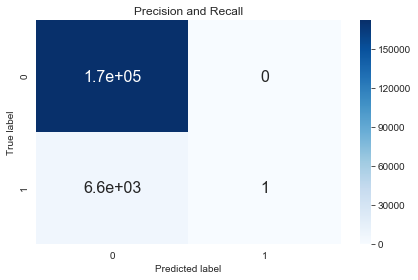

In [39]:
clf = LGBMClassifier(random_state=42, verbose=2)
score = fit_score(clf, x_train, y_train, x_test, y_test, score_metric='binary')
print(score)

y_preds = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_preds)
print(conf_matrix)
fig, ax = plt.subplots()
sns.heatmap(conf_matrix,            
            annot=True, 
            annot_kws={"size": 16}, 
            ax=ax,
            cmap=plt.cm.Blues)
ax.set_title("Precision and Recall")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

Processing with Classifier : LGBMClassifier
Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.97      0.68      0.80    172185
         One       0.06      0.49      0.10      6615

   micro avg       0.67      0.67      0.67    178800
   macro avg       0.51      0.59      0.45    178800
weighted avg       0.94      0.67      0.77    178800

{'desc': 'Classifier : LGBMClassifier', 'train_acc_score': 0.684621284755513, 'train_f1_score': 0.7828295882526172, 'train_prec_score': 0.949785492094312, 'train_rec_score': 0.684621284755513, 'valid_acc_score': 0.6713422818791946, 'valid_f1_score': 0.773103588430723, 'valid_prec_score': 0.938245802438771, 'valid_rec_score': 0.6713422818791948, 'valid_roc_auc': 0.622280519658506}
[[116766  55419]
 [  3345   3270]]


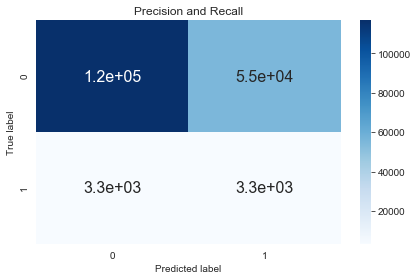

In [40]:
clf = LGBMClassifier(random_state=42, verbose=2, class_weight='balanced')
score = fit_score(clf, x_train, y_train, x_test, y_test, score_metric='weighted')
print(score)

y_preds = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_preds)
print(conf_matrix)
fig, ax = plt.subplots()
sns.heatmap(conf_matrix,            
            annot=True, 
            annot_kws={"size": 16}, 
            ax=ax,
            cmap=plt.cm.Blues)
ax.set_title("Precision and Recall")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

Processing with Classifier : LGBMClassifier
Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.97      0.68      0.80    172185
         One       0.06      0.49      0.10      6615

   micro avg       0.67      0.67      0.67    178800
   macro avg       0.51      0.59      0.45    178800
weighted avg       0.94      0.67      0.77    178800

{'desc': 'Classifier : LGBMClassifier', 'train_acc_score': 0.684621284755513, 'train_f1_score': 0.7828295882526172, 'train_prec_score': 0.949785492094312, 'train_rec_score': 0.684621284755513, 'valid_acc_score': 0.6713422818791946, 'valid_f1_score': 0.773103588430723, 'valid_prec_score': 0.938245802438771, 'valid_rec_score': 0.6713422818791948, 'valid_roc_auc': 0.622280519658506}
[[116766  55419]
 [  3345   3270]]


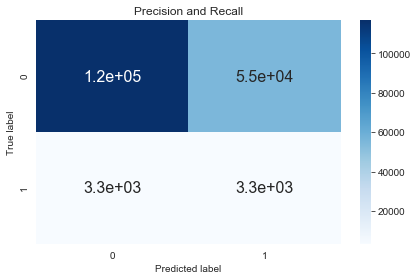

In [41]:
clf = LGBMClassifier(random_state=42, verbose=2, class_weight="balanced", max_depth=15)
score = fit_score(clf, x_train, y_train, x_test, y_test, score_metric='weighted')
print(score)

y_preds = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_preds)
print(conf_matrix)
fig, ax = plt.subplots()
sns.heatmap(conf_matrix,            
            annot=True, 
            annot_kws={"size": 16}, 
            ax=ax,
            cmap=plt.cm.Blues)
ax.set_title("Precision and Recall")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

[1.86872732 0.86872732 0.85875023 ... 0.12379796 0.12378708 0.06888087]
roc_auc =  0.622280519658506


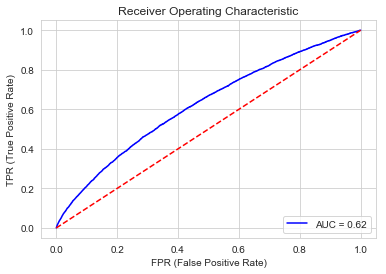

In [42]:
from sklearn.metrics import roc_curve, auc

y_pred_probas = clf.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas)
print(thresholds)
roc_auc = auc(fpr,tpr)
print('roc_auc = ',roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.show()

### LGBMClassifier with scaled data

In [43]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, make_union

numeric_cols = [x for x in x_train.columns if x.startswith('num')]
cat_cols = [x for x in x_train.columns if x.startswith('cat')]
preprocess = make_column_transformer(
    (numeric_cols, RobustScaler()),
    (cat_cols, OneHotEncoder()),
)
lgbm_clf = LGBMClassifier(random_state=42, verbose=2, class_weight='balanced')
clf = make_pipeline(preprocess, lgbm_clf)
clf

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True), ['num1', 'num2', 'num3',...        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0, verbose=2))])

Processing with Classifier : Pipeline


C:\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.97      0.65      0.78    172185
         One       0.06      0.54      0.10      6615

   micro avg       0.65      0.65      0.65    178800
   macro avg       0.52      0.60      0.44    178800
weighted avg       0.94      0.65      0.76    178800

{'desc': 'Classifier : Pipeline', 'train_acc_score': 0.6539477468839885, 'train_f1_score': 0.7606053443465112, 'train_prec_score': 0.9467472769200633, 'train_rec_score': 0.6539477468839885, 'valid_acc_score': 0.646907158836689, 'valid_f1_score': 0.7551508784833583, 'valid_prec_score': 0.9398557366787933, 'valid_rec_score': 0.646907158836689, 'valid_roc_auc': 0.6386867967140846}
[[112068  60117]
 [  3016   3599]]


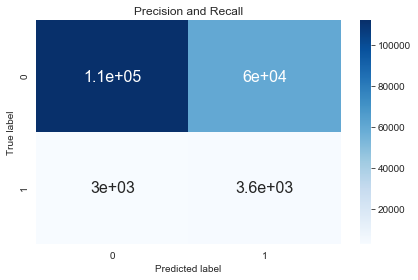

In [44]:
score = fit_score(clf, x_train, y_train, x_test, y_test, score_metric='weighted')
print(score)

y_preds = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_preds)
print(conf_matrix)
fig, ax = plt.subplots()
sns.heatmap(conf_matrix,            
            annot=True, 
            annot_kws={"size": 16}, 
            ax=ax,
            cmap=plt.cm.Blues)
ax.set_title("Precision and Recall")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

### LGBMClassifier on balanced dataset instead of on imbalanced one

#### Use SMOTE to balance our dataset

In [45]:
from imblearn.over_sampling import SMOTE

smote_algo = SMOTE(random_state=42)
smote_data_X,smote_data_Y = smote_algo.fit_sample(x_train, y_train)
smote_data_X = pd.DataFrame(data=smote_data_X,columns=x_train.columns)
smote_data_Y= pd.Series(data=smote_data_Y,name=y_train.name)
smote_data = smote_data_X
smote_data["target"] = smote_data_Y
print('smote_data.shape = ', smote_data.shape)
smote_data.head()

smote_data.shape =  (804198, 40)


num1  num2  num3  num4  num5  num6  num7  num8  num9  num10   ...     cat8  \
0   7.0   4.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0    0.0   ...      1.0   
1   3.0   5.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0    0.0   ...      1.0   
2   1.0   5.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0    0.0   ...      1.0   
3   2.0   5.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0   ...    999.0   
4   2.0   7.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0    0.0   ...      1.0   

   cat9  cat10  cat11  cat12  cat13  cat14  cat6_was_missing  \
0   4.0    1.0    1.0    0.0    1.0  104.0               1.0   
1   1.0    0.0    1.0    0.0    1.0   90.0               1.0   
2   0.0    1.0    1.0    2.0    1.0   32.0               0.0   
3  10.0    1.0    1.0    2.0    1.0   83.0               1.0   
4  11.0    1.0    1.0    0.0    1.0   67.0               1.0   

   cat8_was_missing  target  
0               0.0       0  
1               0.0       0  
2               0.0       0  
3               1.0       0  
4               0.0       0  

[5 rows x 40 columns]

Percentage of good transactions (represented by 0 as target label):  0.5
Percentage of bad transactions (represented by 1 as target label):  0.5
Total number of transactions in balanced data:  804198


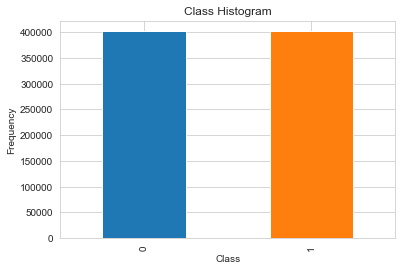

In [46]:
count_of_classes = pd.value_counts(smote_data_Y, sort = True).sort_index()
count_of_classes.plot(kind = 'bar')
plt.title("Class Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

# Showing ratio
print("Percentage of good transactions (represented by 0 as target label): ", len(smote_data_Y[smote_data_Y == 0])/len(smote_data_Y))
print("Percentage of bad transactions (represented by 1 as target label): ", len(smote_data_Y[smote_data_Y == 1])/len(smote_data_Y))
print("Total number of transactions in balanced data: ", len(smote_data_Y))

In [47]:
'''
smote_train_X, smote_test_X, smote_train_Y, smote_test_Y = train_test_split(smote_data_X, smote_data_Y, train_size = 0.70, random_state = 42)
print('smote_train_X.shape = ', smote_train_X.shape)
print('smote_test_X.shape = ', smote_test_X.shape)
smote_train_X.head()
'''

"\nsmote_train_X, smote_test_X, smote_train_Y, smote_test_Y = train_test_split(smote_data_X, smote_data_Y, train_size = 0.70, random_state = 42)\nprint('smote_train_X.shape = ', smote_train_X.shape)\nprint('smote_test_X.shape = ', smote_test_X.shape)\nsmote_train_X.head()\n"

In [48]:
numeric_cols = [x for x in smote_data_X.columns if x.startswith('num')]
cat_cols = [x for x in smote_data_X.columns if x.startswith('cat')]
preprocess = make_column_transformer(
    (numeric_cols, RobustScaler()),
    (cat_cols, OneHotEncoder()),
)
lgbm_clf = LGBMClassifier(random_state=42, verbose=2, class_weight={0:1,1:5})
clf = make_pipeline(preprocess, lgbm_clf)

# Note the usage of smote_data_? here
score = fit_score(clf, smote_data_X, smote_data_Y, x_test, y_test)
print(score)

y_preds = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_preds)
print(conf_matrix)

Processing with Classifier : Pipeline


C:\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.96      1.00      0.98    172185
         One       0.13      0.01      0.02      6615

   micro avg       0.96      0.96      0.96    178800
   macro avg       0.55      0.50      0.50    178800
weighted avg       0.93      0.96      0.94    178800

{'desc': 'Classifier : Pipeline', 'train_acc_score': 0.9796517772986255, 'train_f1_score': 0.9796457698045171, 'train_prec_score': 0.9802187181443048, 'train_rec_score': 0.9796517772986255, 'valid_acc_score': 0.9603635346756152, 'valid_f1_score': 0.9443995182750479, 'valid_prec_score': 0.9326520845962987, 'valid_rec_score': 0.9603635346756152, 'valid_roc_auc': 0.6287159952564687}
[[171627    558]
 [  6529     86]]


#### Final Model

In [54]:
numeric_cols = [x for x in smote_data_X.columns if x.startswith('num')]
cat_cols = [x for x in smote_data_X.columns if x.startswith('cat')]
preprocess = make_column_transformer(
    (numeric_cols, RobustScaler()),
    (cat_cols, OneHotEncoder()),
)
lgbm_clf = LGBMClassifier(random_state=42, n_jobs=-1, verbose=2, class_weight={0:1,1:20}, colsample_bytree=0.8)
clf = make_pipeline(preprocess, lgbm_clf)

# Note the usage of smote_data_? here
score = fit_score(clf, smote_data_X, smote_data_Y, x_test, y_test, score_metric='binary')
print(score)

y_preds = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_preds)
print(conf_matrix)
''' Previous Best: 
@25 ==> 'valid_prec_score': 0.0517, 'valid_rec_score': 0.5876
@20 ==> 'valid_prec_score': 0.0581, 'valid_rec_score': 0.4485
'''

Processing with Classifier : Pipeline


C:\Anaconda3\envs\py36\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Classification Report for Validation Data:
              precision    recall  f1-score   support

        Zero       0.97      0.72      0.83    172185
         One       0.06      0.45      0.10      6615

   micro avg       0.71      0.71      0.71    178800
   macro avg       0.51      0.58      0.47    178800
weighted avg       0.94      0.71      0.80    178800

{'desc': 'Classifier : Pipeline', 'train_acc_score': 0.8520625517596413, 'train_f1_score': 0.8689300654077214, 'train_prec_score': 0.7799965189322616, 'train_rec_score': 0.9807534960295847, 'valid_acc_score': 0.7105592841163311, 'valid_f1_score': 0.10286724681898553, 'valid_prec_score': 0.05809559241056568, 'valid_rec_score': 0.4485260770975057, 'valid_roc_auc': 0.6249451192556409}
[[124081  48104]
 [  3648   2967]]


" Previous Best: \n@25 ==> 'valid_prec_score': 0.0517, 'valid_rec_score': 0.5876\n"